In [34]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("data_news - data_news.csv")
df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [35]:
df.info() #checking for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [36]:
# Drop unnecessary columns
df = df.drop(columns=['links'])

# Filling missing keywords with empty string
df = df.assign(keywords=df['keywords'].fillna(""))

# Function to clean text
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.strip()  # Trim spaces
    return text

# Apply text cleaning
df['headline'] = df['headline'].apply(clean_text)
df['short_description'] = df['short_description'].apply(clean_text)
df['keywords'] = df['keywords'].apply(clean_text)

# Combing columns into a single 'text' column
df = df.assign(text=df['headline'] + " " + df['short_description'] + " " + df['keywords'])

# Drop old text columns
df = df.drop(columns=['headline', 'short_description', 'keywords'])


print(df.head())


   category                                               text
0  WELLNESS  miles in  days lessons learned resting is part...
1  WELLNESS  talking to yourself crazy or crazy helpful thi...
2  WELLNESS  crenezumab trial will gauge whether alzheimers...
3  WELLNESS  oh what a difference she made if you want to b...
4  WELLNESS  green superfoods first the bad news soda bread...


In [37]:
#Step 2: Feature Extraction

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to 5000 for efficiency

# Converting text data into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Geting the target variable (category)
y = df['category']

# Display shape of transformed data
print("TF-IDF Feature Matrix Shape:", X_tfidf.shape)
print("Target Variable Shape:", y.shape)


TF-IDF Feature Matrix Shape: (50000, 5000)
Target Variable Shape: (50000,)


category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64


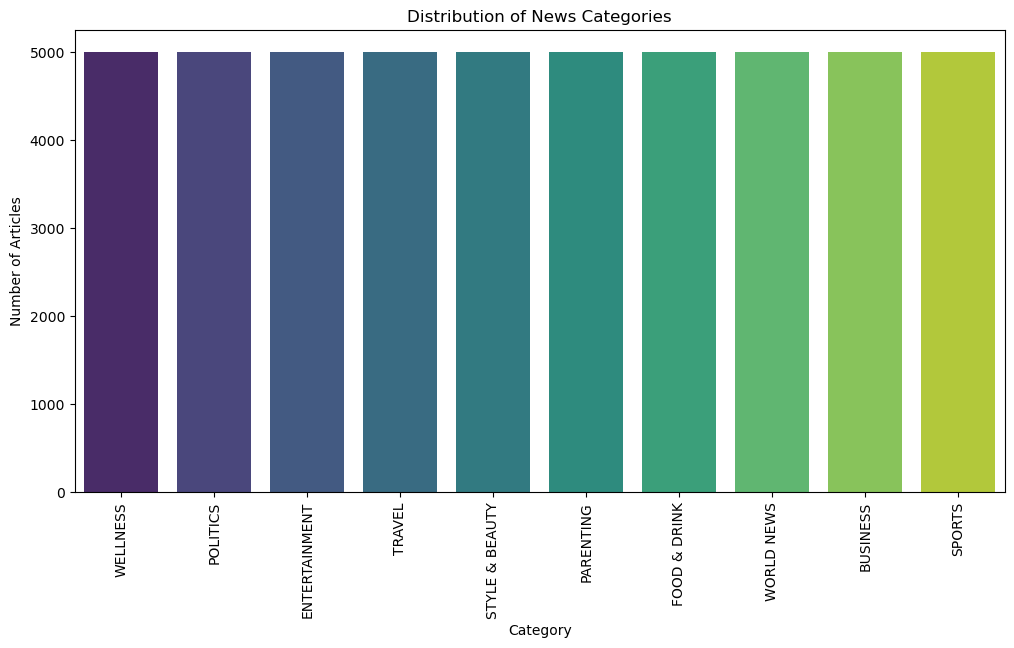

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Counting the number of articles in each category
category_counts = df['category'].value_counts()

# Displaying category distribution
print(category_counts)

# Plot category distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, dodge=False, legend=False, palette="viridis")

plt.xticks(rotation=90) 
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.title("Distribution of News Categories")
plt.show()


In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [41]:
# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.7874
                precision    recall  f1-score   support

      BUSINESS       0.73      0.76      0.74      1000
 ENTERTAINMENT       0.77      0.77      0.77      1000
  FOOD & DRINK       0.83      0.86      0.84      1000
     PARENTING       0.77      0.75      0.76      1000
      POLITICS       0.76      0.74      0.75      1000
        SPORTS       0.86      0.87      0.87      1000
STYLE & BEAUTY       0.88      0.82      0.85      1000
        TRAVEL       0.79      0.78      0.78      1000
      WELLNESS       0.72      0.75      0.73      1000
    WORLD NEWS       0.80      0.77      0.78      1000

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



In [43]:
# Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.7735
                precision    recall  f1-score   support

      BUSINESS       0.74      0.68      0.71      1000
 ENTERTAINMENT       0.80      0.75      0.77      1000
  FOOD & DRINK       0.79      0.87      0.83      1000
     PARENTING       0.66      0.77      0.71      1000
      POLITICS       0.77      0.72      0.75      1000
        SPORTS       0.88      0.83      0.86      1000
STYLE & BEAUTY       0.87      0.81      0.84      1000
        TRAVEL       0.76      0.77      0.77      1000
      WELLNESS       0.71      0.75      0.73      1000
    WORLD NEWS       0.79      0.77      0.78      1000

      accuracy                           0.77     10000
     macro avg       0.78      0.77      0.77     10000
  weighted avg       0.78      0.77      0.77     10000



In [44]:
# Support Vector Machine (SVM) model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.7846
                precision    recall  f1-score   support

      BUSINESS       0.73      0.79      0.75      1000
 ENTERTAINMENT       0.73      0.78      0.75      1000
  FOOD & DRINK       0.81      0.85      0.83      1000
     PARENTING       0.76      0.76      0.76      1000
      POLITICS       0.76      0.74      0.75      1000
        SPORTS       0.88      0.88      0.88      1000
STYLE & BEAUTY       0.88      0.82      0.85      1000
        TRAVEL       0.80      0.75      0.78      1000
      WELLNESS       0.71      0.73      0.72      1000
    WORLD NEWS       0.80      0.76      0.78      1000

      accuracy                           0.78     10000
     macro avg       0.79      0.78      0.78     10000
  weighted avg       0.79      0.78      0.78     10000



In [45]:
# Performing cross-validation on Logistic Regression
cv_scores = cross_val_score(log_reg, X_tfidf, y, cv=5)
print("Logistic Regression Cross-Validation Accuracy:", cv_scores.mean())


Logistic Regression Cross-Validation Accuracy: 0.77696


In [46]:
#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "max_iter": [500, 1000, 1500]  # Increasing iterations for better convergence
}

# Initializing Logistic Regression
logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_logreg = grid_search.best_estimator_

y_pred_best = best_logreg.predict(X_test)
print("Optimized Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best))


Best Parameters: {'C': 1, 'max_iter': 500}
Optimized Logistic Regression Accuracy: 0.7874



Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.73      0.76      0.74      1000
 ENTERTAINMENT       0.77      0.77      0.77      1000
  FOOD & DRINK       0.83      0.86      0.84      1000
     PARENTING       0.77      0.75      0.76      1000
      POLITICS       0.76      0.74      0.75      1000
        SPORTS       0.86      0.87      0.87      1000
STYLE & BEAUTY       0.88      0.82      0.85      1000
        TRAVEL       0.79      0.78      0.78      1000
      WELLNESS       0.72      0.75      0.73      1000
    WORLD NEWS       0.80      0.77      0.78      1000

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



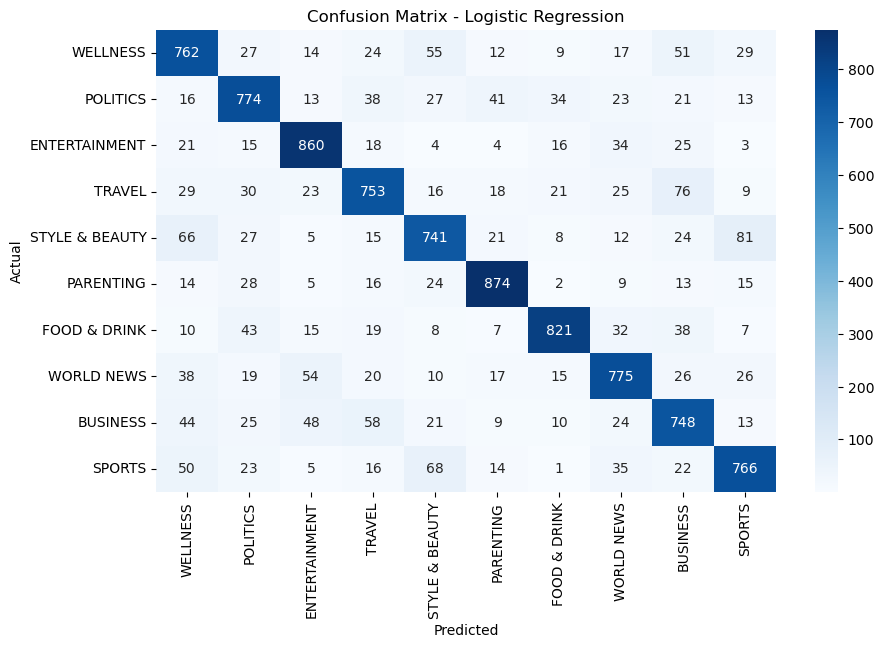

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_best = best_logreg.predict(X_test)

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()
